# Softmax exercise


In this exercise you will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate 
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


If you are not using a linux-computer at IFI, go to in5400/datasets and download the data as described in the knn-notebook.


In [27]:
import random
import numpy as np
from in5400.data_utils import load_CIFAR10
import matplotlib.pyplot as plt




%matplotlib inline

plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [106]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'in5400/datasets/cifar-10-batches-py'
    #cifar10_dir = '/projects/in5400/CIFAR-10/cifar-10-batches-py'
    
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    print('x train ', X_train.shape)
    
    # subsample the data to use the split the training data into a training and a validation subset
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    print('first X train', X_train.shape)
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    print('bias trick', X_train.shape)
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

x train  (50000, 32, 32, 3)
first X train (49000, 3072)
bias trick (49000, 3073)
Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


In [110]:
weight = np.arange(18).reshape(6,3)
bias = np.arange(3)
inp = np.arange(36).reshape(6,6)
a = inp @ weight
b = a + bias
print(a)
print(b)

[[ 165  180  195]
 [ 435  486  537]
 [ 705  792  879]
 [ 975 1098 1221]
 [1245 1404 1563]
 [1515 1710 1905]]
[[ 165  181  197]
 [ 435  487  539]
 [ 705  793  881]
 [ 975 1099 1223]
 [1245 1405 1565]
 [1515 1711 1907]]


## Softmax Classifier

Your code for this section will all be written inside **in5400/classifiers/softmax.py**. 
The loss for one sample is 
$L_i = -\log\left(\frac{e^{f_{y_i}}}{ \sum_j e^{f_j} }\right) \hspace{0.5in}$

You should sum over all samples

In [25]:
from in5400.classifiers.softmax import one_hot
x = [1,2,3,4,5,9]
print(one_hot(x))

[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [92]:
def softmax(x):
    print(x.max(axis=1))
    print(x.max(axis=1, keepdims = True))
    print(x.max())
    x = x - x.max(axis = 1, keepdims = True)
    t = x - np.log(np.sum(np.exp(x), axis = 1, keepdims = True))
    return np.exp(t)
b = np.arange(18).reshape(6,3)

print(np.sum(softmax(b), axis = 1))

a = np.arange(18).reshape(6,3)
b = np.arange(18).reshape(6,3)
print(a)
print(np.sum(a*b, axis = 1))

[ 2  5  8 11 14 17]
[[ 2]
 [ 5]
 [ 8]
 [11]
 [14]
 [17]]
17
[1. 1. 1. 1. 1. 1.]
[[ 0  1  2]
 [ 3  4  5]
 [ 6  7  8]
 [ 9 10 11]
 [12 13 14]
 [15 16 17]]
[  5  50 149 302 509 770]


In [96]:
# First implement the naive softmax loss function with nested loops.
# Open the file inf5860/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from in5400.classifiers.softmax import softmax_loss_naive, one_hot, softmax
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

(500, 10)
(500, 10)
[[ 0.08833551  0.14377423  0.13409854 ...  0.04932898  0.10983206
   0.04953264]
 [-0.89690752  0.11464019  0.07647937 ...  0.05632914  0.09280853
   0.11630287]
 [ 0.07765827 -0.92753498  0.080015   ...  0.09733774  0.08246265
   0.11591882]
 ...
 [ 0.0922222   0.06033008  0.06336701 ...  0.17649528  0.11120681
  -0.882136  ]
 [ 0.10671869  0.14199556  0.09988135 ...  0.05753191  0.11290691
   0.08012567]
 [-0.8557291   0.07730139  0.0803284  ...  0.04069534  0.05514832
   0.13000251]]
(500, 10)
loss: 2.347576
sanity check: 2.302585


## Inline Question 1:

To answer inline questions: double click on this cell and you will be able to edit it. Fill in your text answer below.

Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *Fill this in*


In [12]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev)

# Use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from in5400.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)



numerical: 0.000000 analytic: 0.000000, relative error: nan
numerical: 0.000000 analytic: 0.000000, relative error: nan
numerical: 0.000000 analytic: 0.000000, relative error: nan
numerical: 0.000000 analytic: 0.000000, relative error: nan
numerical: 0.000000 analytic: 0.000000, relative error: nan
numerical: 0.000000 analytic: 0.000000, relative error: nan
numerical: 0.000000 analytic: 0.000000, relative error: nan
numerical: 0.000000 analytic: 0.000000, relative error: nan
numerical: 0.000000 analytic: 0.000000, relative error: nan
numerical: 0.000000 analytic: 0.000000, relative error: nan


Since the numbers are small, the gradient are also small, and your difference should also be very small, arbound e-07 or smaller

In [13]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from in5400.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))


grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 0.000000e+00 computed in 0.000161s
vectorized loss: 0.000000e+00 computed in 0.000345s
Loss difference: 0.000000
Gradient difference: 0.000000


The difference in loss should be smaller than 0.1, and the gradient difference close to 0. 


In [99]:
# Use the validation set to tune hyperparameters # learning rate). You should experiment with different ranges for the learning
# rates; if you are careful you should be able to
# get a classification accuracy of 30% on the validation set.
from in5400.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7]


################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
for lr in np.linspace(learning_rates[0], learning_rates[1], 5):
    
        softmax = Softmax()
        loss_hist = softmax.train(X_train, y_train, learning_rate=lr, num_iters=1000, verbose=True)        
        y_train_acc = (softmax.predict(X_train) == y_train).mean()
        y_val_acc = (softmax.predict(X_val) == y_val).mean()
        results[(lr)] = (y_train_acc, y_val_acc)
        if y_val_acc > best_val:
            best_val = y_val_acc
            best_softmax = softmax
            
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr  in sorted(results):
    train_accuracy, val_accuracy = results[(lr)]
    print('lr %e train accuracy: %f val accuracy: %f' % (
                lr,  train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)




iteration 0 / 1000: loss 6.106017
iteration 100 / 1000: loss 7.418529
iteration 200 / 1000: loss 6.279965
iteration 300 / 1000: loss 3.991774
iteration 400 / 1000: loss 4.242794
iteration 500 / 1000: loss 6.909081
iteration 600 / 1000: loss 6.127337
iteration 700 / 1000: loss 5.187592
iteration 800 / 1000: loss 5.674059
iteration 900 / 1000: loss 4.378246
iteration 0 / 1000: loss 6.062792
iteration 100 / 1000: loss 9.053170
iteration 200 / 1000: loss 7.290269
iteration 300 / 1000: loss 14.282995
iteration 400 / 1000: loss 8.249983
iteration 500 / 1000: loss 13.420369
iteration 600 / 1000: loss 9.251466
iteration 700 / 1000: loss 12.959246
iteration 800 / 1000: loss 11.810757
iteration 900 / 1000: loss 16.834578
iteration 0 / 1000: loss 5.286579
iteration 100 / 1000: loss 24.628949
iteration 200 / 1000: loss 15.986894
iteration 300 / 1000: loss 14.873345
iteration 400 / 1000: loss 13.335058
iteration 500 / 1000: loss 23.474865
iteration 600 / 1000: loss 17.008241
iteration 700 / 1000: l

In [104]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.317000


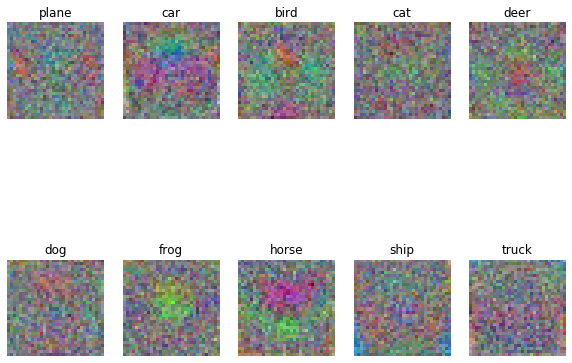

In [105]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])